Model selection and cross-validation for soil moisture mapping
---------------------------------------------------------------

This notebook trains multiple models for soil moisture prediction maps. 
The model training data is based on weekly averaged soil moisture probes and multiple spatial-temporal dependent covariates. 

The prediction models that are tested are based on Gaussian Process regression with two different base function: Random Forest (RF) and Bayesian Linear Regression (BLR). The base functions are used to account for the non-linear relationship between the covariates and the soil moisture. Gaussian Process Regression (GPR) is used to account for the spatial-temporal correlation of the soil moisture probes. When GPR is enabled, base model were used as the mean function of GPR.

The model selection is based on the cross-validation of the prediction error (normalized RMSE, R2) for the test data.
Test data is selected based on n-fold cross-validation. Different test data is selected for each fold.

Note that test data is n-fold split based on the spatial location of the probes, and not on time. If test data would be selected based on unique location in space and time rather than on space only, the cross-validation would reveal in superficial low prediction errors, because the temporal variability of the soil moisture over short time periods is very low relative to the spatial variations, and hence test data would be strongly correlated with the training data.

User settings, such as input/output paths and all other options, are set in the settings file, e.g.:

`settings_testmodel_temporal.yaml`

This package is part of the machine learning project developed for the Agricultural Research Federation (AgReFed).

## Library imports

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import yaml
import argparse
from types import SimpleNamespace  
from matplotlib.image import imread
import time

# Custom local libraries:
sys.path.append('../../python_scripts')

from utils import print2, truncate_data
from preprocessing import gen_kfold
import GPmodel as gp # GP model plus kernel functions and distance matrix calculation
import model_blr as blr
import model_rf as rf
from soilmod_xval import runmodel


 ## Reading and process settings

 All settings are specified in the .yaml file to make analysis reproducible. Below we will read and inspect the settings.

In [2]:
# Define name of settings file to save configuration
fname_settings = 'settings_testmodel_temporal.yaml'
path_settings = '.'

In [3]:
# Load settings from yaml file
with open(os.path.join(path_settings,fname_settings), 'r') as f:
    settings = yaml.load(f, Loader=yaml.FullLoader)
# Parse settings dictinary as namespace (settings are available as 
# settings.variable_name rather than settings['variable_name'])
settings = SimpleNamespace(**settings)


# Add temporal or vertical component
if settings.axistype == 'temporal':
    settings.colname_zcoord = settings.colname_tcoord
    settings.colname_zmin = settings.colname_tmin
    settings.colname_zmax =  settings.colname_tmax

if type(settings.model_functions) != list:
    settings.model_functions = [settings.model_functions]

# check if outpath exists, if not create direcory
os.makedirs(settings.outpath, exist_ok = True)

# Intialise output info file:
print('init')
print(f'--- Parameter Settings ---')
print(f'Selected Model Functions: {settings.model_functions}')
print(f'Target Name: {settings.name_target}')
print(f'--------------------------')

# Print features selected
print("")
print("--- Features Selected ---")
for key in settings.__dict__:
    if key == "name_features":
        for feature in settings.name_features:
            print(f"'{feature}'")

init
--- Parameter Settings ---
Selected Model Functions: ['rf', 'blr', 'rf-gp', 'blr-gp']
Target Name: SM
--------------------------

--- Features Selected ---
'DepthBot'
'DepthTop'
'Bucket'
'ET20m_df_999'
'CLY'
'SOC'
'NDVI_95'
'SND'
'Rain_df_999'
'TWI'
'ET20m_df_90'
'ET20m_df_99'
'ET20m'
'Rain'
'NDVI_50'
'ET20m_df_95'
'Total'
'Rain_df_99'
'Rain_df_50'
'ET20m_df_70'
'ET20m_df_50'


## Data Preprocessing

The data preprocessing includes the following steps:
 - reading in the dataset from .csv file into pandas dataframe
 - checking coordinate names and converting if necessary to default name convention (x,y,z)
 - select data for top soil only
 - generating n-fold cross-validation test sets
 - converting coordinates to origin at x,y = 0,0

In [4]:
print('Reading data into dataframe...')
# Read in data
dfsel = pd.read_csv(os.path.join(settings.inpath, settings.infname))

# Rename x and y coordinates of input data
if settings.colname_xcoord != 'x':
    dfsel.rename(columns={settings.colname_xcoord: 'x'}, inplace = True)
if settings.colname_ycoord != 'y':
    dfsel.rename(columns={settings.colname_ycoord: 'y'}, inplace = True)
if (settings.axistype == 'vertical') & (settings.colname_zcoord != 'z'):
    dfsel.rename(columns={settings.colname_zcoord: 'z'}, inplace = True)
else:
    dfsel.rename(columns={settings.colname_tcoord: 'z'}, inplace = True)
    dfsel.rename(columns={settings.colname_zcoord: 'z'}, inplace = True)
settings.name_features.append('z')

# Select data between zmin and zmax
dfsel = dfsel[(dfsel['z'] >= settings.colname_zmin) & (dfsel['z'] <= settings.colname_zmax)]

# Generate n-fold indices
print(f'Generating {settings.nfold}-fold test sets based on moisture probe locations..')
dfsel = gen_kfold(dfsel, nfold = settings.nfold, label_nfold = 'nfold', id_unique = ['z'], precision_unique = 0.01, sort=True)
# dfsel = gen_kfold(dfsel, nfold = settings.nfold, label_nfold = 'nfold', id_unique = ['x', 'y'], precision_unique = 0.01, sort=False)

## Get coordinates for training data and set coord origin to (0,0)
print(f'Setting coordinate origin to (0,0)...')
bound_xmin = dfsel.x.min()
bound_xmax = dfsel.x.max()
bound_ymin = dfsel.y.min()
bound_ymax = dfsel.y.max()

# Set origin to (0,0)
dfsel['x'] = dfsel['x'] - bound_xmin
dfsel['y'] = dfsel['y'] - bound_ymin

print('Preprocessing data finished.')


Reading data into dataframe...
Generating 3-fold test sets based on moisture probe locations..
Setting coordinate origin to (0,0)...
Preprocessing data finished.


## Train and test multiple models

Here we train and test multiple models as specified in the settings: settings.model_functions.
The models are a combination of Gaussian Process regression with either a Random Forest or Bayesian linear regression model as base function.

This training step will take a couple of minutes given that a new model needs to be trained and evaluated for each cross-validation and model type.

The results for each model are saved as:
- RMSE:  root mean squared error
- NRMSE: normalized RMSE to standard deviation
- NRMedSE: Normalized root median SE
- R2: coefficient of determination
- LCCC: Lin's concordance correlation coefficient
- NSE: Nash-Sutcliffe efficiency
- Theta: Mean ratio of true error squared divided by predicted error squared for test data

In [5]:
# Define stats result lists
stats_summaries = []

# Loop over model functions and evaluate
for model_function in settings.model_functions:
    # run and evaluate model
    time_start = time.time()
    dfsum, stats_summary, model_outpath = runmodel(dfsel, model_function, settings)
    time_end = time.time()
    print(f'Time elapsed: {(time_end - time_start)/3600} hours.)')
    print(f'All output files of {model_function} saved in {model_outpath}')
    print('')
    # save results
    stats_summaries.append(stats_summary)


Computing 3-fold xrossvalidation for function model: rf
Processing for nfold  1
Using default hyperparameters for Random Forest
RMSE:  37.9509
Normalized RMSE:  1.2038
Normalized ROOT MEDIAN SE:  0.5052
R^2:  -0.4491
Lin's CCC:  0.5388
Nash Sutcliffe Efficiency:  -0.4491
Mean Theta:  7.2468
Median Theta:  1.0
Processing for nfold  2
Using default hyperparameters for Random Forest
RMSE:  22.0926
Normalized RMSE:  0.6704
Normalized ROOT MEDIAN SE:  0.3313
R^2:  0.5505
Lin's CCC:  0.7204
Nash Sutcliffe Efficiency:  0.5505
Mean Theta:  1.8631
Median Theta:  1.0
Processing for nfold  3
Using default hyperparameters for Random Forest
RMSE:  26.0784
Normalized RMSE:  0.7503
Normalized ROOT MEDIAN SE:  0.4237
R^2:  0.4371
Lin's CCC:  0.7562
Nash Sutcliffe Efficiency:  0.4371
Mean Theta:  1.7221
Median Theta:  1.0
Saving all predictions in dataframe ...
---- X-validation Summary -----
Mean RMSE: 28.707 +/- 6.736
Mean normalized RMSE: 0.875 +/- 0.235
Median normalized RMSE: 0.424
Mean R^2: 0.18


In [ ]:
for model_function, stats_summary in zip(settings.model_functions, stats_summaries):
    print(f'--- {model_function} ---')
    for key, value in stats_summary.items():
        print(f'{key}: \t{value[0]}\t\u00b1 {value[1]}')

## Show summary of results

Results for each cross-validation set (here 8) are saved in a separate folder, including result csv files multiple plots for residual analysis and ground truth versus prediction. To inspect please check images in output folder. Here we show only a few overview results of the combined cross-validation results.

In [25]:
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'font.family': 'Arial'})
plt.rcParams.update({'axes.titlesize': 10})
plt.rcParams.update({'axes.labelsize': 8})
plt.rcParams.update({'xtick.labelsize': 8})
plt.rcParams.update({'ytick.labelsize': 8})
plt.rcParams.update({'legend.fontsize': 8})
plt.rcParams.update({'figure.dpi': 100})
# Set bar chart color
# colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']

### Results for intercomparison

In [49]:
# Function: Plot stats of all models

def plot_models_nfold(respaths, modelnames, statname = 'RMSE'):

    dfstats = []
    for respath in respaths:
        dfstats.append(pd.read_csv(os.path.join(respath,f'{settings.name_target}_nfold_summary_stats.csv')))

    fig, ax = plt.subplots(1,1, figsize = (6,2))
    # plot bars for each model side by side
    count = len(modelnames)
    width = 1/(count+1)
    mid = width * (count-1)/2

    # set color cycle
    ax.set_prop_cycle(color = ['tab:blue', 'tab:blue', 'tab:red', 'tab:red', 'tab:green', 'tab:green', 'tab:orange', 'tab:orange'])

    for df, modelname, idx in zip(dfstats, modelnames, range(0, len(modelnames))):
        hatch = '///' if 'GP' in modelname else ''
        # Other hatch options: https://matplotlib.org/3.1.1/gallery/shapes_and_collections/hatch_style_reference.html

        ax.bar(df.nfold - mid + idx*width, df[statname], label = modelname + ' model', 
               alpha = 0.6, width = width, edgecolor = 'k', linewidth = 1, hatch = hatch)
        # df.plot(y=statname, x = 'nfold', kind = 'bar', title = f'{statname} for {modelname}', ax=ax)
    ax.set_xlim(0.5, settings.nfold+0.5)
    ax.set_xticks(range(1,settings.nfold+1))
    ax.set_xticklabels(range(1,settings.nfold+1))

    ax.set_xlabel('X-validation fold')
    ax.set_title(f'{statname} for all models')
    ax.legend()
    plt.savefig(os.path.join(settings.outpath, f'results_{statname}_nfold.png'))
    plt.show()


In [ ]:
# Function: Plot stats of all models
def plot_models(respaths, modelnames, statname = 'RMSE'):

    dfstats = []
    for respath in respaths:
        dfstats.append(pd.read_csv(os.path.join(respath,f'{settings.name_target}_nfold_summary_stats.csv')))

    fig, ax = plt.subplots(1,1, figsize = (4,2), dpi=100)

    # set color cycle
    ax.set_prop_cycle(color = ['tab:blue', 'tab:blue', 'tab:red', 'tab:red'])

    df_out = []
    for df, modelname, idx in zip(dfstats, modelnames, range(0, len(modelnames))):
        hatch = '///' if 'GP' in modelname else ''
        df_mean = df.mean()
        df_std = df.std()

        df_out.append(pd.DataFrame({modelname + ' mean': df_mean, modelname + ' std':df_std}).drop('nfold'))
        
        ax.bar(idx, df_mean[statname], yerr = df_std[statname], label = modelname,
               alpha = 0.6,  edgecolor = 'k', linewidth = 1, hatch = hatch)

    df_out = pd.concat(df_out, axis = 1)
    df_out.to_csv(os.path.join(settings.outpath, 'results_stats.csv'))

    # Grid line for y = 0

    ax.set_xticks(range(0,len(modelnames)))
    ax.set_xticklabels(modelnames, ha = 'center')
    ax.set_ylabel(statname)
    ax.set_title(f'{statname} for all models')
    if (ax.get_ylim()[0]) < 0:
        ax.axhline(y=0, color='k', linestyle='--', lw=1)
    fig.subplots_adjust(hspace=0.4, wspace=0.2, left=0.15, right=0.95, bottom=0.12, top=0.88)
    # Set background color to transparent
    # fig.patch.set_facecolor('none')
    # ax.patch.set_facecolor('none')
    
    plt.savefig(os.path.join(settings.outpath, f'results_{statname}.png'), dpi=300, transparent=True)
    plt.show()


#### Statistics of folds

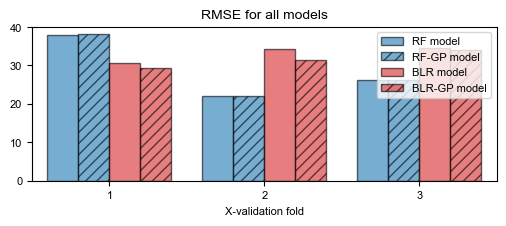

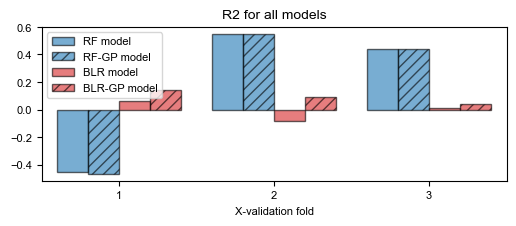

In [50]:
respaths = [os.path.join(settings.outpath, f'Xval_{settings.nfold}-fold_rf_{settings.name_target}'),
            os.path.join(settings.outpath, f'Xval_{settings.nfold}-fold_rf-gp_{settings.name_target}'),
            os.path.join(settings.outpath, f'Xval_{settings.nfold}-fold_blr_{settings.name_target}'),
            os.path.join(settings.outpath, f'Xval_{settings.nfold}-fold_blr-gp_{settings.name_target}'),
            ]

modelnames = ['RF',
              'RF-GP',
              'BLR',
              'BLR-GP'
              ]
# Statistics of folds
plot_models_nfold(respaths, modelnames, statname = 'RMSE')
plot_models_nfold(respaths, modelnames, statname = 'R2')

#### Statistics of fold mean

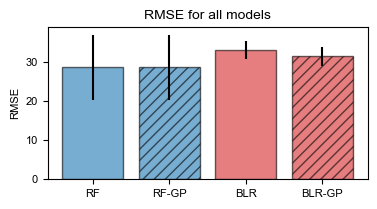

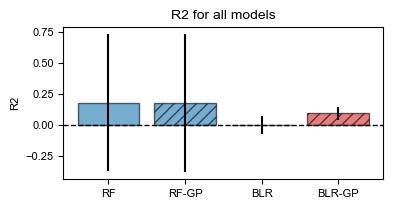

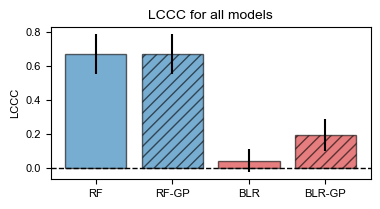

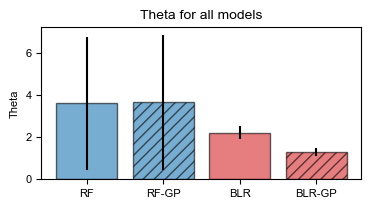

In [47]:
plot_models(respaths, modelnames, statname = 'RMSE')
plot_models(respaths, modelnames, statname = 'R2')
plot_models(respaths, modelnames, statname = 'LCCC')
plot_models(respaths, modelnames, statname = 'Theta')

#### GPR Parameters

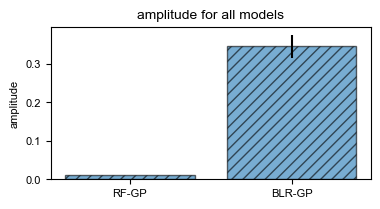

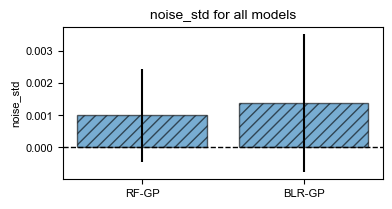

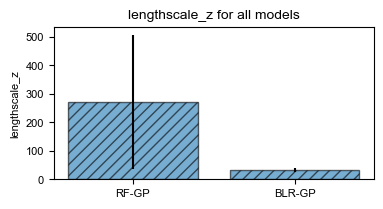

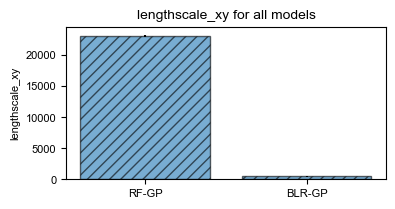

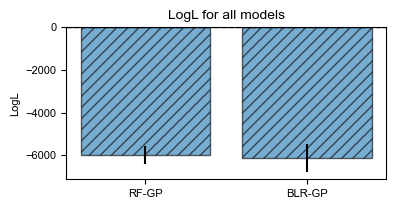

In [46]:
respaths_gp = respaths[1:4:2]
modelnames_gp = modelnames[1:4:2]
plot_models(respaths_gp, modelnames_gp, statname = 'amplitude')
plot_models(respaths_gp, modelnames_gp, statname = 'noise_std')
plot_models(respaths_gp, modelnames_gp, statname = 'lengthscale_z')
plot_models(respaths_gp, modelnames_gp, statname = 'lengthscale_xy')
plot_models(respaths_gp, modelnames_gp, statname = 'LogL')